NOTE: Dependencies for the project are listed below:
- scipy==1.2.1
- pandas==0.25.1 
- numpy==1.17.2
- matplotlib==3.1.2
- tqdm==4.41.0
- impyute==0.0.8

## Importing libraries

In [1]:
from scipy import stats

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [4]:
from impyute.imputation.cs import fast_knn

## Reading Data

In [5]:
working_data = pd.read_csv('Hackathon_Working_Data.csv')
validation_data = pd.read_csv('Hackathon_Validation_Data.csv')
mapping_file= pd.read_csv('Hackathon_Mapping_File.csv')
ideal_data = pd.read_csv('Hackathon_Ideal_Data.csv')
submit = pd.read_csv('Sample Submission.csv')

In [6]:
print('Working Data')
working_data.head()
print('Validation Data')
validation_data.head()
print('Ideal Data')
ideal_data.head()
submit.head()

Working Data


,MONTH,STORECODE,DAY,BILL_ID,BILL_AMT,QTY,VALUE,PRICE,GRP,SGRP,SSGRP,CMP,MBRD,BRD
0,M1,N1,4,T375,225.0,1.0,225.0,225.0,BUTTER MARGR (4/94),BUTTER,SALTED,G C M M F,AMUL,AMUL
1,M1,N1,4,T379,95.0,1.0,95.0,95.0,CONFECTIONERY - ECLAIRS,CONFECTIONERY - ECLAIRS,CONFECTIONERY - ECLAIRS,PARLE PRODS,MELODY,MELODY CHOCOLATY
2,M1,N1,4,T381,10.0,1.0,10.0,10.0,CHOCOLATE,CHOCOLATE PANNED,CHOCOLATE PANNED,MONDELEZ INTERNATIONAL,CADBURY SHOTS,CADBURY SHOTS
3,M1,N1,4,T382,108.0,1.0,108.0,108.0,PACKAGED TEA,MAIN PACKS,MAIN PACKS,GUJ TEA PROCESSORS,WAGH BAKRI,WAGH BAKRI INSTANT
4,M1,N1,4,T384,19.0,1.0,19.0,19.0,ALL IODISED SALT,POWDERED SALT,POWDERED SALT,TATA CHEM,TATA,TATA SALT


Validation Data


,ID,STORECODE,MONTH,GRP
0,1112535,N1,M1,AFTER SHAVE LOTIONS
1,1112539,N1,M1,AGARBATTI & DHOOPBATTI
2,1112543,N1,M1,ALL AIR FRESHNERS(01/03)
3,1112547,N1,M1,ALL IODISED SALT
4,1112551,N1,M1,ANTACIDS


Ideal Data


,MONTH,STORECODE,QTY,VALUE,GRP,SGRP,SSGRP,CMP,MBRD,BRD
0,M1,P1,25,83,HAIR CONDITIONERS,HAIR CONDITIONERS,HAIR CONDITIONERS,HINDUSTAN UNILEVER LIMITED,DOVE,DOVE HAIR FALL RESCUE
1,M1,P1,6,22,HAIR CONDITIONERS,HAIR CONDITIONERS,HAIR CONDITIONERS,HINDUSTAN UNILEVER LIMITED,DOVE,DOVE INTENSE REPAIR
2,M1,P1,4,15,HAIR CONDITIONERS,HAIR CONDITIONERS,HAIR CONDITIONERS,HINDUSTAN UNILEVER LIMITED,DOVE,DOVE OXYGEN MOISTURE
3,M1,P1,15,60,HAIR CONDITIONERS,HAIR CONDITIONERS,HAIR CONDITIONERS,L'OREAL INDIA,GARNIER,FRUCTIS
4,M1,P2,0,0,HAIR CONDITIONERS,HAIR CONDITIONERS,HAIR CONDITIONERS,HINDUSTAN UNILEVER LIMITED,CLINIC PLUS,CLINIC PLUS


,ID,TOTALVALUE
0,1112535,0
1,1112539,1
2,1112543,2
3,1112547,3
4,1112551,4


## Idea derivation

In [7]:
ideal_data_grouped = ideal_data.groupby(['STORECODE', 'MONTH', 'GRP'])['VALUE'].sum().reset_index()

<BarContainer object of 66 artists>

<BarContainer object of 67 artists>

<BarContainer object of 66 artists>

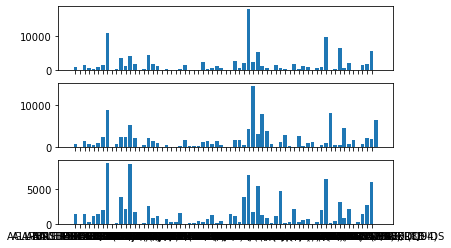

In [8]:
fig, ax = plt.subplots(3,1, sharex =True)

for i, month in enumerate(['M1','M2','M3']):
    df = ideal_data_grouped[(ideal_data_grouped['MONTH']==month) & (ideal_data_grouped['STORECODE']=='P1')].copy()
    ax[i].bar(df['GRP'], df['VALUE'], align='center')

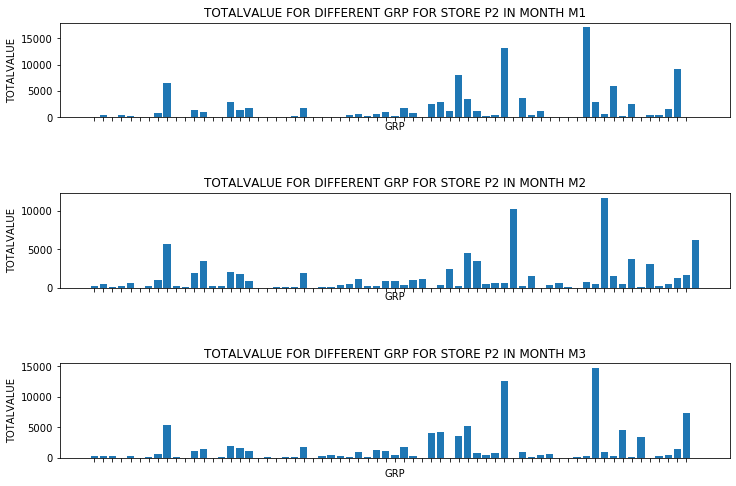

In [9]:
fig, ax = plt.subplots(3,1, sharex =True, figsize=(12,8))
plt.subplots_adjust(hspace=0.8)
for i, month in enumerate(['M1','M2','M3']):
    df = ideal_data_grouped[(ideal_data_grouped['MONTH']==month) & (ideal_data_grouped['STORECODE']=='P2')].copy()
    _ =ax[i].bar(df['GRP'], df['VALUE'], align='center')
    _ =ax[i].set_xticklabels( '', rotation=90)
    _ =ax[i].set_ylabel('TOTALVALUE')
    _ =ax[i].set_xlabel('GRP')
    _ =ax[i].set_title(f'TOTALVALUE FOR DIFFERENT GRP FOR STORE P2 IN MONTH {month}')

<BarContainer object of 65 artists>

<BarContainer object of 66 artists>

<BarContainer object of 66 artists>

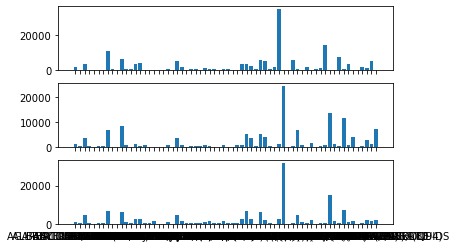

In [10]:
fig, ax = plt.subplots(3,1, sharex =True)

for i, month in enumerate(['M1','M2','M3']):
    df = ideal_data_grouped[(ideal_data_grouped['MONTH']==month) & (ideal_data_grouped['STORECODE']=='P3')].copy()
    ax[i].bar(df['GRP'], df['VALUE'], align='center')

>Conclusion - Same store, same group, different month => Same value

## Some anomalous groups 

In [11]:
set(working_data['GRP'].unique()) - set(validation_data['GRP'].unique())

{'BUTTER MARGR  (4/94)',
 'CHEESE        (4/94)',
 'DIAPERS       (8/93)',
 'HAIR DYES     (1/76)',
 'HOME INSECTICIDES CTG  (8/93)',
 'LIQUID TOILET SOAPS  (8/93)',
 'NON-REFINED OILS   (9/93)',
 'TOOTH BRUSH   (7/93)'}

In [12]:
set(validation_data['GRP'].unique()) - set(working_data['GRP'].unique())

{'BUTTER MARGR (4/94)',
 'CHEESE (4/94)',
 'DIAPERS (8/93)',
 'HAIR DYES (1/76)',
 'HOME INSECTICIDES CTG (8/93)',
 'LIQUID TOILET SOAPS (8/93)',
 'MOSQUITO REPELLANT EQUIP(4/97)',
 'NON-REFINED OILS (9/93)',
 'TOOTH BRUSH (7/93)'}

In [13]:
#Fixing the space in the working data group
working_data['GRP'] = working_data['GRP'].apply(lambda x: ' '.join(x.split()))

In [14]:
set(working_data['GRP'].unique()) - set(validation_data['GRP'].unique())

set()

In [15]:
set(validation_data['GRP'].unique()) - set(working_data['GRP'].unique())

{'MOSQUITO REPELLANT EQUIP(4/97)'}

## Initialising Procedure

In [16]:
validation_data['key']=[1]*validation_data.shape[0]

In [17]:
list_of_days = list(range(1,32))

In [18]:
whole_incomplete_data = pd.merge(validation_data, pd.DataFrame({'key':[1]*31,'DAY':list_of_days}), on='key').drop('key',axis=1)

In [19]:
validation_data.drop('key',axis =1, inplace=True)

In [20]:
working_data_grp_grouped = working_data.groupby(['STORECODE','MONTH','GRP','DAY'])['VALUE'].sum().reset_index()

In [21]:
working_data_grp_grouped.head()

,STORECODE,MONTH,GRP,DAY,VALUE
0,N1,M1,AGARBATTI & DHOOPBATTI,5,10.0
1,N1,M1,AGARBATTI & DHOOPBATTI,6,20.0
2,N1,M1,AGARBATTI & DHOOPBATTI,7,10.0
3,N1,M1,AGARBATTI & DHOOPBATTI,15,20.0
4,N1,M1,AGARBATTI & DHOOPBATTI,17,10.0


In [22]:
whole_partial_data = pd.merge(whole_incomplete_data, working_data_grp_grouped, on =['STORECODE','MONTH','GRP','DAY'], how='left')

## Algorithm Idea
### Using the observation `Same store, same group, different month => Same value`, derived assumption 2

### `Same store, same group, same day, different month => similar value`

In [23]:
whole_partial_data_table_2 = pd.pivot_table(whole_partial_data,values='VALUE',index =['STORECODE','MONTH','DAY'], columns='GRP',dropna=False).reset_index().set_index(['STORECODE','DAY','MONTH'])

In [24]:
whole_partial_data_table_2.head()

GRP                  AFTER SHAVE LOTIONS  AGARBATTI & DHOOPBATTI  \
STORECODE DAY MONTH                                                
N1        1   M1                     NaN                     NaN   
          2   M1                     NaN                     NaN   
          3   M1                     NaN                     NaN   
          4   M1                     NaN                     NaN   
          5   M1                     NaN                    10.0   

GRP                  ALL AIR FRESHNERS(01/03)  ALL IODISED SALT  ANTACIDS  \
STORECODE DAY MONTH                                                         
N1        1   M1                          NaN               NaN       NaN   
          2   M1                          NaN               NaN       NaN   
          3   M1                          NaN               NaN       NaN   
          4   M1                         44.0             127.0       8.0   
          5   M1                         45.0              21.0       NaN   

GRP                  ANTISEPTIC CREAMS  ANTISEPTIC LIQUIDS (4/97)  BABY FOODS  \
STORECODE DAY MONTH                                                             
N1        1   M1                   NaN                        NaN         NaN   
          2   M1                   NaN                        NaN         NaN   
          3   M1                   NaN                        NaN         NaN   
          4   M1                   NaN                        NaN         NaN   
          5   M1                   NaN                        NaN         NaN   

GRP                  BABY OILS / MASSAGE OILS  BATTERIES  BEVERAGES  \
STORECODE DAY MONTH                                                   
N1        1   M1                          NaN        NaN        NaN   
          2   M1                          NaN        NaN        NaN   
          3   M1                          NaN        NaN        NaN   
          4   M1                          NaN        NaN       55.0   
          5   M1                          NaN       28.0        NaN   

GRP                  BISCUITS - CORE & NON CORE  BLUES  BREAKFAST CEREALS  \
STORECODE DAY MONTH                                                         
N1        1   M1                            NaN    NaN                NaN   
          2   M1                            NaN    NaN                NaN   
          3   M1                            NaN    NaN                NaN   
          4   M1                         531.67    NaN               80.0   
          5   M1                         322.90    NaN                9.8   

GRP                  BUTTER MARGR (4/94)  ...  SHOE POLISHES  SKIN CREAMS  \
STORECODE DAY MONTH                       ...                               
N1        1   M1                     NaN  ...            NaN          NaN   
          2   M1                     NaN  ...            NaN          NaN   
          3   M1                     NaN  ...            NaN          NaN   
          4   M1                   271.0  ...            NaN          NaN   
          5   M1                   265.0  ...            NaN         94.0   

GRP                  SOAP CAKES/BARS  SPICES (03/04)  \
STORECODE DAY MONTH                                    
N1        1   M1                 NaN             NaN   
          2   M1                 NaN             NaN   
          3   M1                 NaN             NaN   
          4   M1                 NaN            38.0   
          5   M1                 NaN            81.0   

GRP                  SQSH CRDLS & SFT DRNK-CONVERTD  SUGAR SUBSTITUTE (11/05)  \
STORECODE DAY MONTH                                                             
N1        1   M1                                NaN                       NaN   
          2   M1                                NaN                       NaN   
          3   M1                                NaN                       NaN   
          4   M1                       

In [25]:
# Data null initially
whole_partial_data_table_2.isna().sum().sum()/ (whole_partial_data_table_2.shape[0] * whole_partial_data_table_2.shape[1])

0.8597238815876809

In [26]:
whole_partial_data_table_2.loc[('N1',4)]

C:\Users\AADARSH\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning:

indexing past lexsort depth may impact performance.



GRP,AFTER SHAVE LOTIONS,AGARBATTI & DHOOPBATTI,ALL AIR FRESHNERS(01/03),ALL IODISED SALT,ANTACIDS,ANTISEPTIC CREAMS,ANTISEPTIC LIQUIDS (4/97),BABY FOODS,BABY OILS / MASSAGE OILS,BATTERIES,BEVERAGES,BISCUITS - CORE & NON CORE,BLUES,BREAKFAST CEREALS,BUTTER MARGR (4/94),...,SHOE POLISHES,SKIN CREAMS,SOAP CAKES/BARS,SPICES (03/04),SQSH CRDLS & SFT DRNK-CONVERTD,SUGAR SUBSTITUTE (11/05),TALCUM POWDERS,TOILET SOAPS (04/00),TOOTH BRUSH (7/93),TOOTH PASTES,TOOTH POWDERS,TWIN BLADES,VANASPATI CONS PACK (8/94),VERMICELLI & NOODLE,WASHING POWDERS/LIQUIDS
MONTH,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
M1,NaN,NaN,44.0,127.0,8.0,NaN,NaN,NaN,NaN,NaN,55.0,531.67,NaN,80.0,271.0,...,NaN,NaN,NaN,38.0,NaN,NaN,NaN,94.5,58.0,90.0,NaN,NaN,NaN,184.0,134.0
M2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,NaN,NaN,NaN,NaN,NaN,NaN,40.0
M3,NaN,NaN,NaN,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,155.00,NaN,90.0,266.0,...,NaN,28.0,NaN,253.0,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,282.0,171.0,39.6


In [27]:
whole_partial_data_table_2.loc[('N1',4)].fillna(whole_partial_data_table_2.loc[('N1',4)].mean())

C:\Users\AADARSH\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning:

indexing past lexsort depth may impact performance.



GRP,AFTER SHAVE LOTIONS,AGARBATTI & DHOOPBATTI,ALL AIR FRESHNERS(01/03),ALL IODISED SALT,ANTACIDS,ANTISEPTIC CREAMS,ANTISEPTIC LIQUIDS (4/97),BABY FOODS,BABY OILS / MASSAGE OILS,BATTERIES,BEVERAGES,BISCUITS - CORE & NON CORE,BLUES,BREAKFAST CEREALS,BUTTER MARGR (4/94),...,SHOE POLISHES,SKIN CREAMS,SOAP CAKES/BARS,SPICES (03/04),SQSH CRDLS & SFT DRNK-CONVERTD,SUGAR SUBSTITUTE (11/05),TALCUM POWDERS,TOILET SOAPS (04/00),TOOTH BRUSH (7/93),TOOTH PASTES,TOOTH POWDERS,TWIN BLADES,VANASPATI CONS PACK (8/94),VERMICELLI & NOODLE,WASHING POWDERS/LIQUIDS
MONTH,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
M1,NaN,NaN,44.0,127.0,8.0,NaN,NaN,NaN,NaN,NaN,55.0,531.670,NaN,80.0,271.0,...,NaN,28.0,NaN,38.0,NaN,NaN,NaN,94.50,58.0,90.0,NaN,NaN,282.0,184.0,134.0
M2,NaN,NaN,44.0,73.5,8.0,NaN,NaN,NaN,NaN,NaN,55.0,343.335,NaN,85.0,30.0,...,NaN,28.0,NaN,145.5,NaN,NaN,NaN,32.00,58.0,50.0,NaN,NaN,282.0,177.5,40.0
M3,NaN,NaN,44.0,20.0,8.0,NaN,NaN,NaN,NaN,NaN,55.0,155.000,NaN,90.0,266.0,...,NaN,28.0,NaN,253.0,NaN,NaN,NaN,63.25,58.0,10.0,NaN,NaN,282.0,171.0,39.6


In [28]:
## algo3- Same store, same day, same group, different month - same data
for store in tqdm(list(map(lambda x: 'N'+str(x), range(1,11)))):
    for day in range(1,32):
        whole_partial_data_table_2.loc[(store,day)].fillna(whole_partial_data_table_2.loc[(store,day)].mean(), inplace=True)

C:\Users\AADARSH\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



C:\Users\AADARSH\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: PerformanceWarning:

indexing past lexsort depth may impact performance.



In [29]:
whole_partial_data_table_2.head()

GRP                  AFTER SHAVE LOTIONS  AGARBATTI & DHOOPBATTI  \
STORECODE DAY MONTH                                                
N1        1   M1                     NaN                     NaN   
          2   M1                     NaN                     NaN   
          3   M1                     NaN                     NaN   
          4   M1                     NaN                     NaN   
          5   M1                     NaN                    10.0   

GRP                  ALL AIR FRESHNERS(01/03)  ALL IODISED SALT  ANTACIDS  \
STORECODE DAY MONTH                                                         
N1        1   M1                          NaN               NaN       NaN   
          2   M1                          NaN               NaN       NaN   
          3   M1                          NaN              19.0      16.0   
          4   M1                         44.0             127.0       8.0   
          5   M1                         45.0              21.0       NaN   

GRP                  ANTISEPTIC CREAMS  ANTISEPTIC LIQUIDS (4/97)  BABY FOODS  \
STORECODE DAY MONTH                                                             
N1        1   M1                   NaN                        NaN         NaN   
          2   M1                   NaN                        NaN         NaN   
          3   M1                   NaN                        NaN         NaN   
          4   M1                   NaN                        NaN         NaN   
          5   M1                   NaN                        NaN         NaN   

GRP                  BABY OILS / MASSAGE OILS  BATTERIES  BEVERAGES  \
STORECODE DAY MONTH                                                   
N1        1   M1                          NaN        NaN        5.0   
          2   M1                          NaN        NaN       10.0   
          3   M1                          NaN       26.0       10.0   
          4   M1                          NaN        NaN       55.0   
          5   M1                          NaN       28.0        NaN   

GRP                  BISCUITS - CORE & NON CORE  BLUES  BREAKFAST CEREALS  \
STORECODE DAY MONTH                                                         
N1        1   M1                         190.00   22.0                NaN   
          2   M1                          97.40    NaN               19.8   
          3   M1                          65.00    NaN               12.5   
          4   M1                         531.67    NaN               80.0   
          5   M1                         322.90    NaN                9.8   

GRP                  BUTTER MARGR (4/94)  ...  SHOE POLISHES  SKIN CREAMS  \
STORECODE DAY MONTH                       ...                               
N1        1   M1                     NaN  ...            NaN         11.0   
          2   M1                   491.0  ...            NaN          NaN   
          3   M1                   153.5  ...            NaN          NaN   
          4   M1                   271.0  ...            NaN         28.0   
          5   M1                   265.0  ...            NaN         94.0   

GRP                  SOAP CAKES/BARS  SPICES (03/04)  \
STORECODE DAY MONTH                                    
N1        1   M1                 NaN           37.24   
          2   M1                 NaN           62.80   
          3   M1                 NaN            5.40   
          4   M1                 NaN           38.00   
          5   M1                 NaN           81.00   

GRP                  SQSH CRDLS & SFT DRNK-CONVERTD  SUGAR SUBSTITUTE (11/05)  \
STORECODE DAY MONTH                                                             
N1        1   M1                                NaN                       NaN   
          2   M1                               30.0                       NaN   
          3   M1                              140.0                       NaN   
          4   M1                       

In [30]:
# Data null after first imputation step
whole_partial_data_table_2.isna().sum().sum()/ (whole_partial_data_table_2.shape[0] * whole_partial_data_table_2.shape[1])

0.7099561927518917

In [29]:
algo3_baseline_data  = whole_partial_data_table_2.stack().reset_index().groupby(['STORECODE','MONTH','GRP'])[0].sum().reset_index()

In [30]:
algo3_baseline_data.rename(columns = {0:'TOTALVALUE'}, inplace=True)

In [31]:
algo3_baselined_submission = pd.merge(validation_data,algo3_baseline_data, how='left',on=['STORECODE','MONTH','GRP']).fillna(0).drop(['STORECODE','MONTH','GRP'], axis=1)
algo3_baselined_submission.columns = ['ID','TOTALVALUE']
algo3_baselined_submission['TOTALVALUE'] = algo3_baselined_submission['TOTALVALUE'].astype('int')

In [32]:
algo3_baselined_submission.to_csv('algo3_baseline_check.csv',index=False)

> Obtained Score - 2389.4291343469

## Improvement using Assumption 1

In [31]:
# Data null from intermediate stage before grouping
whole_partial_data_table_2.isna().sum().sum()/ (whole_partial_data_table_2.shape[0] * whole_partial_data_table_2.shape[1])

0.7099561927518917

In [32]:
whole_partial_data_table_3 = whole_partial_data_table_2.reset_index().set_index(['STORECODE','MONTH','DAY'])

In [33]:
# Data null initially in new table
whole_partial_data_table_3.isna().sum().sum()/ (whole_partial_data_table_3.shape[0] * whole_partial_data_table_3.shape[1])

0.7099561927518917

In [41]:
# with pd.option_context('max_rows',31):
#     whole_partial_data_table_3.loc[('N2', 'M1')]

GRP,AFTER SHAVE LOTIONS,AGARBATTI & DHOOPBATTI,ALL AIR FRESHNERS(01/03),ALL IODISED SALT,ANTACIDS,ANTISEPTIC CREAMS,ANTISEPTIC LIQUIDS (4/97),BABY FOODS,BABY OILS / MASSAGE OILS,BATTERIES,BEVERAGES,BISCUITS - CORE & NON CORE,BLUES,BREAKFAST CEREALS,BUTTER MARGR (4/94),...,SHOE POLISHES,SKIN CREAMS,SOAP CAKES/BARS,SPICES (03/04),SQSH CRDLS & SFT DRNK-CONVERTD,SUGAR SUBSTITUTE (11/05),TALCUM POWDERS,TOILET SOAPS (04/00),TOOTH BRUSH (7/93),TOOTH PASTES,TOOTH POWDERS,TWIN BLADES,VANASPATI CONS PACK (8/94),VERMICELLI & NOODLE,WASHING POWDERS/LIQUIDS
DAY,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NaN,150.0,125.0,NaN,NaN,NaN,NaN,NaN,NaN,72.0,NaN,392.0,NaN,NaN,386.0,...,NaN,NaN,NaN,84.0,NaN,NaN,NaN,440.0,NaN,20.0,NaN,NaN,NaN,NaN,265.0
2,NaN,215.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,295.0,250.0,NaN,NaN,NaN,...,NaN,NaN,NaN,133.0,155.0,63.0,92.0,192.0,NaN,NaN,138.0,NaN,NaN,50.0,219.0
3,NaN,100.0,414.0,NaN,NaN,NaN,NaN,NaN,NaN,45.0,NaN,235.0,NaN,NaN,225.0,...,50.0,NaN,NaN,148.0,144.0,150.0,NaN,80.0,NaN,196.5,69.0,NaN,NaN,NaN,199.0
4,NaN,NaN,NaN,28.0,110.0,NaN,NaN,NaN,NaN,48.0,NaN,140.0,NaN,NaN,138.0,...,NaN,180.0,NaN,223.5,NaN,NaN,45.0,161.0,NaN,141.0,NaN,NaN,NaN,26.0,740.0
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,165.0,NaN,NaN,450.0,...,110.0,NaN,NaN,72.0,130.0,124.0,NaN,58.0,NaN,88.0,NaN,NaN,NaN,12.0,888.0
6,NaN,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,280.0,NaN,190.0,317.0,...,NaN,NaN,NaN,119.5,115.0,NaN,NaN,380.0,NaN,282.0,NaN,NaN,NaN,NaN,201.0
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,500.0,30.0,NaN,NaN,NaN,...,NaN,NaN,NaN,106.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90.0,NaN,220.0,NaN,95.0,NaN,...,NaN,NaN,NaN,287.0,144.0,80.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.0
9,NaN,NaN,125.0,NaN,NaN,NaN,NaN,NaN,NaN,90.0,NaN,665.0,260.0,499.0,46.0,...,NaN,NaN,NaN,NaN,NaN,63.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
# for i, x in whole_partial_data_table_3.loc[('N2', 'M1')].iterrows():
#     if any([not np.isnan(i) for i in x.values]):
#         whole_partial_data_table_3.loc[('N2', 'M1',i),:] = [0 if np.isnan(i) else i for i in x.values] 
# with pd.option_context('max_rows',31):
#     whole_partial_data_table_3.loc[('N2', 'M1')]

GRP,AFTER SHAVE LOTIONS,AGARBATTI & DHOOPBATTI,ALL AIR FRESHNERS(01/03),ALL IODISED SALT,ANTACIDS,ANTISEPTIC CREAMS,ANTISEPTIC LIQUIDS (4/97),BABY FOODS,BABY OILS / MASSAGE OILS,BATTERIES,BEVERAGES,BISCUITS - CORE & NON CORE,BLUES,BREAKFAST CEREALS,BUTTER MARGR (4/94),...,SHOE POLISHES,SKIN CREAMS,SOAP CAKES/BARS,SPICES (03/04),SQSH CRDLS & SFT DRNK-CONVERTD,SUGAR SUBSTITUTE (11/05),TALCUM POWDERS,TOILET SOAPS (04/00),TOOTH BRUSH (7/93),TOOTH PASTES,TOOTH POWDERS,TWIN BLADES,VANASPATI CONS PACK (8/94),VERMICELLI & NOODLE,WASHING POWDERS/LIQUIDS
DAY,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,150.0,125.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0,0.0,392.0,0.0,0.0,386.0,...,0.0,0.0,0.0,84.0,0.0,0.0,0.0,440.0,0.0,20.0,0.0,0.0,0.0,0.0,265.0
2,0.0,215.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,295.0,250.0,0.0,0.0,0.0,...,0.0,0.0,0.0,133.0,155.0,63.0,92.0,192.0,0.0,0.0,138.0,0.0,0.0,50.0,219.0
3,0.0,100.0,414.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0,0.0,235.0,0.0,0.0,225.0,...,50.0,0.0,0.0,148.0,144.0,150.0,0.0,80.0,0.0,196.5,69.0,0.0,0.0,0.0,199.0
4,0.0,0.0,0.0,28.0,110.0,0.0,0.0,0.0,0.0,48.0,0.0,140.0,0.0,0.0,138.0,...,0.0,180.0,0.0,223.5,0.0,0.0,45.0,161.0,0.0,141.0,0.0,0.0,0.0,26.0,740.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,165.0,0.0,0.0,450.0,...,110.0,0.0,0.0,72.0,130.0,124.0,0.0,58.0,0.0,88.0,0.0,0.0,0.0,12.0,888.0
6,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,280.0,0.0,190.0,317.0,...,0.0,0.0,0.0,119.5,115.0,0.0,0.0,380.0,0.0,282.0,0.0,0.0,0.0,0.0,201.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,500.0,30.0,0.0,0.0,0.0,...,0.0,0.0,0.0,106.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,220.0,0.0,95.0,0.0,...,0.0,0.0,0.0,287.0,144.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67.0
9,0.0,0.0,125.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,665.0,260.0,499.0,46.0,...,0.0,0.0,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
# whole_partial_data_table_3.loc[('N2', 'M1')] = fast_knn(whole_partial_data_table_3.loc[('N2', 'M1')].values, k =30)
# with pd.option_context('max_rows',31):
#     whole_partial_data_table_3.loc[('N2', 'M1')]

GRP,AFTER SHAVE LOTIONS,AGARBATTI & DHOOPBATTI,ALL AIR FRESHNERS(01/03),ALL IODISED SALT,ANTACIDS,ANTISEPTIC CREAMS,ANTISEPTIC LIQUIDS (4/97),BABY FOODS,BABY OILS / MASSAGE OILS,BATTERIES,BEVERAGES,BISCUITS - CORE & NON CORE,BLUES,BREAKFAST CEREALS,BUTTER MARGR (4/94),...,SHOE POLISHES,SKIN CREAMS,SOAP CAKES/BARS,SPICES (03/04),SQSH CRDLS & SFT DRNK-CONVERTD,SUGAR SUBSTITUTE (11/05),TALCUM POWDERS,TOILET SOAPS (04/00),TOOTH BRUSH (7/93),TOOTH PASTES,TOOTH POWDERS,TWIN BLADES,VANASPATI CONS PACK (8/94),VERMICELLI & NOODLE,WASHING POWDERS/LIQUIDS
DAY,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,150.000000,125.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,72.000000,0.000000,392.000000,0.000000,0.000000,386.000000,...,0.000000,0.000000,0.0,84.000000,0.000000,0.000000,0.000000,440.000000,0.000000,20.000000,0.000000,0.0,0.0,0.000000,265.000000
2,0.0,215.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,295.000000,250.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,133.000000,155.000000,63.000000,92.000000,192.000000,0.000000,0.000000,138.000000,0.0,0.0,50.000000,219.000000
3,0.0,100.000000,414.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,45.000000,0.000000,235.000000,0.000000,0.000000,225.000000,...,50.000000,0.000000,0.0,148.000000,144.000000,150.000000,0.000000,80.000000,0.000000,196.500000,69.000000,0.0,0.0,0.000000,199.000000
4,0.0,0.000000,0.000000,28.000000,110.000000,0.0,0.000000,0.0,0.0,48.000000,0.000000,140.000000,0.000000,0.000000,138.000000,...,0.000000,180.000000,0.0,223.500000,0.000000,0.000000,45.000000,161.000000,0.000000,141.000000,0.000000,0.0,0.0,26.000000,740.000000
5,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,165.000000,0.000000,0.000000,450.000000,...,110.000000,0.000000,0.0,72.000000,130.000000,124.000000,0.000000,58.000000,0.000000,88.000000,0.000000,0.0,0.0,12.000000,888.000000
6,0.0,50.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,280.000000,0.000000,190.000000,317.000000,...,0.000000,0.000000,0.0,119.500000,115.000000,0.000000,0.000000,380.000000,0.000000,282.000000,0.000000,0.0,0.0,0.000000,201.000000
7,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,500.000000,30.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
8,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,90.000000,0.000000,220.000000,0.000000,95.000000,0.000000,...,0.000000,0.000000,0.0,287.000000,144.000000,80.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,67.000000
9,0.0,0.000000,125.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,90.000000,0.000000,665.000000,260.000000,499.000000,46.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,63.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000


In [34]:
for month in tqdm(['M1','M2','M3']):
    for store in tqdm(list(map(lambda x: 'N'+str(x), range(1,11)))):
        nan_present= False
        for i, x in whole_partial_data_table_3.loc[(store,month)].iterrows():
            if any([not np.isnan(i) for i in x.values]):
                whole_partial_data_table_3.loc[(store,month,i),:] = [0 if np.isnan(i) else i for i in x.values] 
                #replacing nan values with 0 if even one purchase was recorded,\
            else:
                nan_present = True
                #leaving the whole thing as it is. To be imputed later.
        if nan_present:
            print(f"Imputing in ({month, store})")
            #Mean of Whole data other than the outlier        
    #         df = whole_partial_data_table_3.loc[(store, month)].copy()
    #         whole_partial_data_table_3.loc[(store,month)].fillna(df[np.abs(df-df.mean()) <= (3*df.std())].mean(), inplace=True)
            #KNN
            whole_partial_data_table_3.loc[(store,month)] = fast_knn(whole_partial_data_table_3.loc[(store,month)].values, k =30)

C:\Users\AADARSH\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



C:\Users\AADARSH\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Imputing in (('M1', 'N2'))
Imputing in (('M1', 'N3'))
Imputing in (('M1', 'N4'))
Imputing in (('M1', 'N5'))
Imputing in (('M1', 'N6'))
Imputing in (('M1', 'N7'))
Imputing in (('M1', 'N9'))



Imputing in (('M2', 'N2'))
Imputing in (('M2', 'N3'))
Imputing in (('M2', 'N4'))
Imputing in (('M2', 'N5'))
Imputing in (('M2', 'N6'))
Imputing in (('M2', 'N7'))
Imputing in (('M2', 'N9'))



Imputing in (('M3', 'N2'))
Imputing in (('M3', 'N3'))
Imputing in (('M3', 'N4'))
Imputing in (('M3', 'N5'))
Imputing in (('M3', 'N6'))
Imputing in (('M3', 'N7'))
Imputing in (('M3', 'N9'))




In [35]:
# Data null finally in new table
whole_partial_data_table_3.isna().sum().sum()/ (whole_partial_data_table_3.shape[0] * whole_partial_data_table_3.shape[1])

0.0

In [36]:
whole_partial_data_table_3.head()

GRP                  AFTER SHAVE LOTIONS  AGARBATTI & DHOOPBATTI  \
STORECODE MONTH DAY                                                
N1        M1    1                    0.0                     0.0   
                2                    0.0                     0.0   
                3                    0.0                     0.0   
                4                    0.0                     0.0   
                5                    0.0                    10.0   

GRP                  ALL AIR FRESHNERS(01/03)  ALL IODISED SALT  ANTACIDS  \
STORECODE MONTH DAY                                                         
N1        M1    1                         0.0               0.0       0.0   
                2                         0.0               0.0       0.0   
                3                         0.0              19.0      16.0   
                4                        44.0             127.0       8.0   
                5                        45.0              21.0       0.0   

GRP                  ANTISEPTIC CREAMS  ANTISEPTIC LIQUIDS (4/97)  BABY FOODS  \
STORECODE MONTH DAY                                                             
N1        M1    1                  0.0                        0.0         0.0   
                2                  0.0                        0.0         0.0   
                3                  0.0                        0.0         0.0   
                4                  0.0                        0.0         0.0   
                5                  0.0                        0.0         0.0   

GRP                  BABY OILS / MASSAGE OILS  BATTERIES  BEVERAGES  \
STORECODE MONTH DAY                                                   
N1        M1    1                         0.0        0.0        5.0   
                2                         0.0        0.0       10.0   
                3                         0.0       26.0       10.0   
                4                         0.0        0.0       55.0   
                5                         0.0       28.0        0.0   

GRP                  BISCUITS - CORE & NON CORE  BLUES  BREAKFAST CEREALS  \
STORECODE MONTH DAY                                                         
N1        M1    1                        190.00   22.0                0.0   
                2                         97.40    0.0               19.8   
                3                         65.00    0.0               12.5   
                4                        531.67    0.0               80.0   
                5                        322.90    0.0                9.8   

GRP                  BUTTER MARGR (4/94)  ...  SHOE POLISHES  SKIN CREAMS  \
STORECODE MONTH DAY                       ...                               
N1        M1    1                    0.0  ...            0.0         11.0   
                2                  491.0  ...            0.0          0.0   
                3                  153.5  ...            0.0          0.0   
                4                  271.0  ...            0.0         28.0   
                5                  265.0  ...            0.0         94.0   

GRP                  SOAP CAKES/BARS  SPICES (03/04)  \
STORECODE MONTH DAY                                    
N1        M1    1                0.0           37.24   
                2                0.0           62.80   
                3                0.0            5.40   
                4                0.0           38.00   
                5                0.0           81.00   

GRP                  SQSH CRDLS & SFT DRNK-CONVERTD  SUGAR SUBSTITUTE (11/05)  \
STORECODE MONTH DAY                                                             
N1        M1    1                               0.0                       0.0   
                2                              30.0                       0.0   
                3                             140.0                       0.0   
                4                      

In [37]:
whole_complete_data_2 = pd.DataFrame(whole_partial_data_table_3.stack()).reset_index().rename(columns={0:'VALUE'})
whole_complete_data_2.head()

,STORECODE,MONTH,DAY,GRP,VALUE
0,N1,M1,1,AFTER SHAVE LOTIONS,0.0
1,N1,M1,1,AGARBATTI & DHOOPBATTI,0.0
2,N1,M1,1,ALL AIR FRESHNERS(01/03),0.0
3,N1,M1,1,ALL IODISED SALT,0.0
4,N1,M1,1,ANTACIDS,0.0


In [38]:
whole_complete_data_with_id = pd.merge(whole_partial_data, whole_complete_data_2, on = ['STORECODE','MONTH','DAY','GRP'], how = 'inner').drop('VALUE_x',axis=1)

In [39]:
whole_complete_data_with_id.head()

,ID,STORECODE,MONTH,GRP,DAY,VALUE_y
0,1112535,N1,M1,AFTER SHAVE LOTIONS,1,0.0
1,1112535,N1,M1,AFTER SHAVE LOTIONS,2,0.0
2,1112535,N1,M1,AFTER SHAVE LOTIONS,3,0.0
3,1112535,N1,M1,AFTER SHAVE LOTIONS,4,0.0
4,1112535,N1,M1,AFTER SHAVE LOTIONS,5,0.0


In [40]:
submit = whole_complete_data_with_id.groupby('ID')['VALUE_y'].sum().reset_index()
submit.columns = ['ID','TOTALVALUE']
submit['TOTALVALUE'] = submit['TOTALVALUE'].astype('int')
submit.head()

,ID,TOTALVALUE
0,1112535,0
1,1112539,125
2,1112543,164
3,1112547,661
4,1112551,171


In [41]:
submit.to_csv('final_submission.csv',index=False)

> Obtained Score - 2359.0151807577